In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomogr

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


Load config

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
im = InstrumentManager()

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

# Sweep qubits

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [9]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 807.6606640920804, HWHM 1.1161142026002508
Found peak in I at [MHz] 807.4676035773609, HWHM 0.9911317130162793
Found peak in Q at [MHz] 807.6631824535182, HWHM 1.1292557062438537


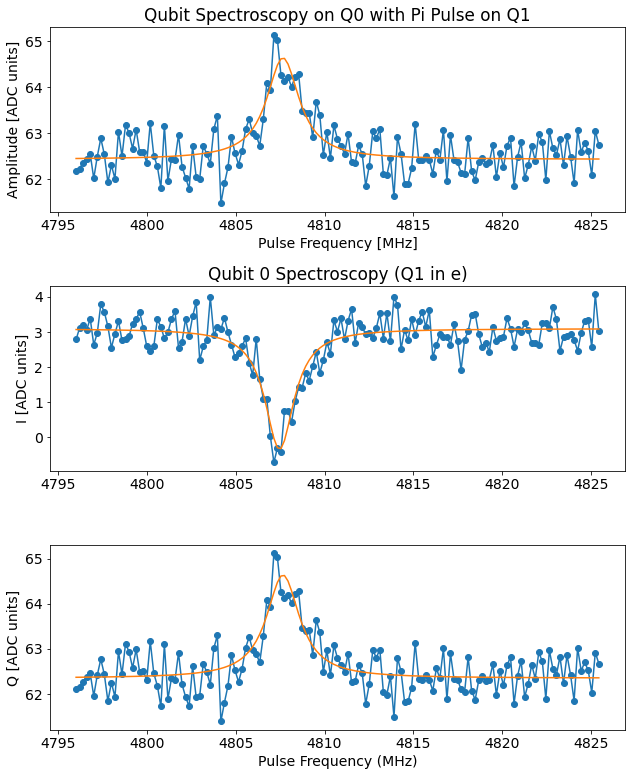

Fit Q0 frequency with ZZ shift [MHz]: 807.4676035773609
Q0 shift due to Q1 in e [MHz]: -3.3589383676320494


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 808.0020873969931, HWHM 0.5995354648397494
Found peak in I at [MHz] 807.9988631550358, HWHM 0.6149724965466609
Found peak in Q at [MHz] 808.0061926697737, HWHM 0.6326627037040118


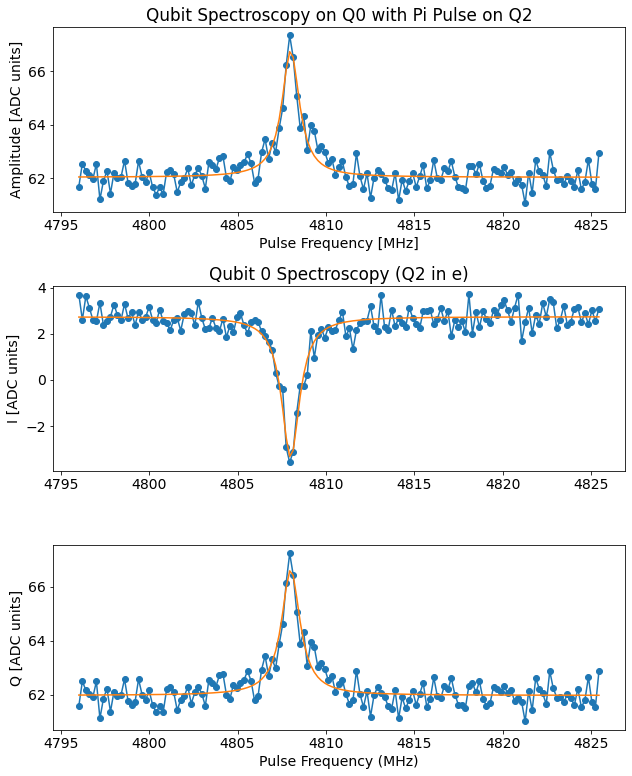

Fit Q0 frequency with ZZ shift [MHz]: 807.9988631550358
Q0 shift due to Q2 in e [MHz]: -2.82767878995719


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 807.7572218640005, HWHM 0.7824453155541783
Found peak in I at [MHz] 807.8009195439092, HWHM -0.8248935657213738
Found peak in Q at [MHz] 807.7587968738463, HWHM 0.8083706374699009


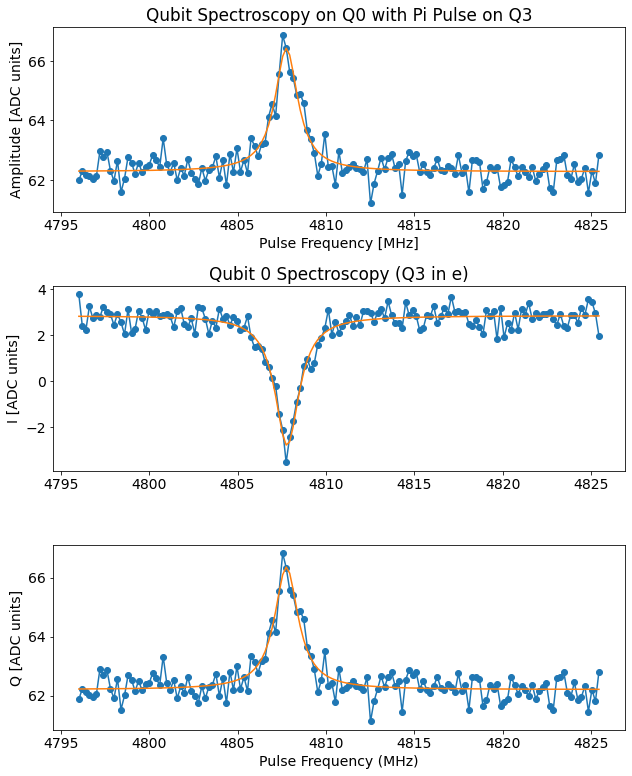

Fit Q0 frequency with ZZ shift [MHz]: 807.8009195439092
Q0 shift due to Q3 in e [MHz]: -3.0256224010837514


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3463.974126972329, HWHM 1.8290154438878656
Found peak in I at [MHz] 3464.0331612471955, HWHM 1.817199904571393
Found peak in Q at [MHz] 3463.7841380440523, HWHM 1.8848094001030162


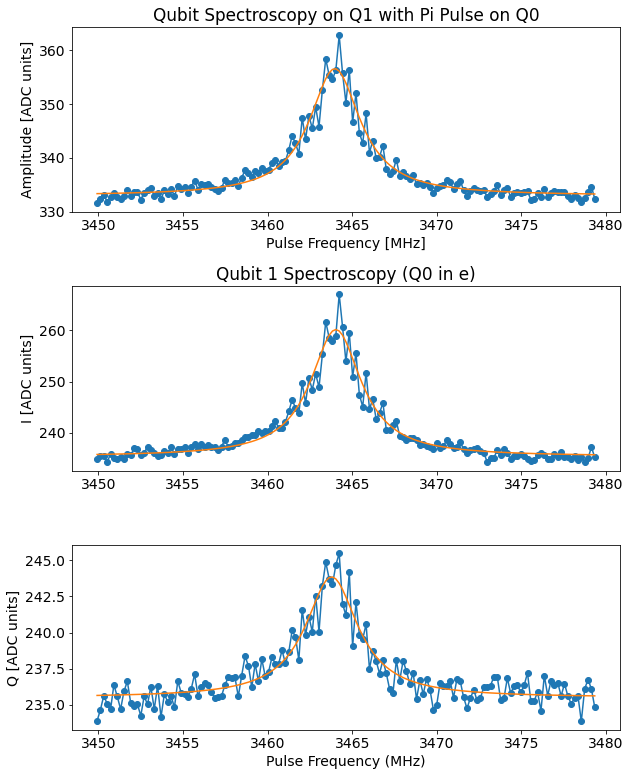

Fit Q1 frequency with ZZ shift [MHz]: 3464.0331612471955
Q1 shift due to Q0 in e [MHz]: -0.6943271490713414


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3460.1102113126763, HWHM 3.113333714121753
Found peak in I at [MHz] 3460.395140656578, HWHM 3.4139626397506957
Found peak in Q at [MHz] 3459.614051184737, HWHM 2.6316696137448363


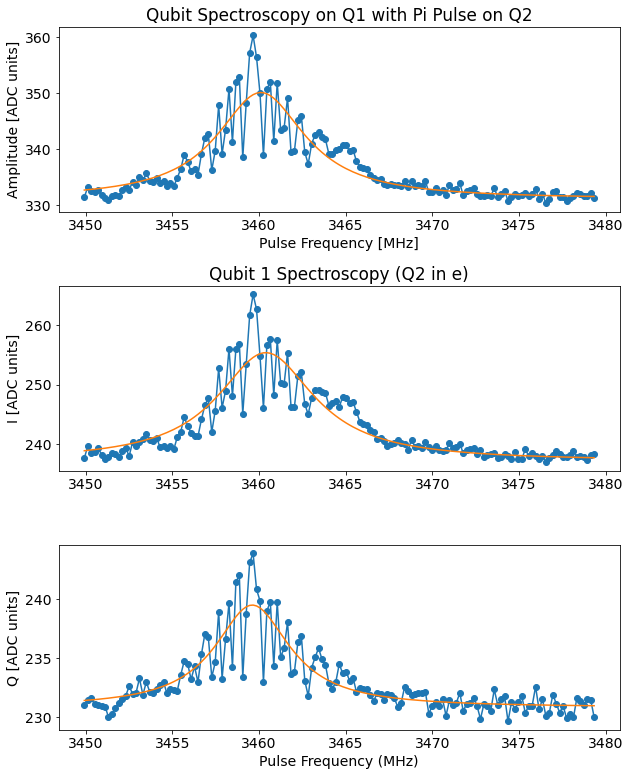

Fit Q1 frequency with ZZ shift [MHz]: 3459.614051184737
Q1 shift due to Q2 in e [MHz]: -5.113437211529799


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3463.681407481036, HWHM 2.122523442491601
Found peak in I at [MHz] 3463.784664890342, HWHM 2.236007423040297
Found peak in Q at [MHz] 3463.460851813258, HWHM 1.8044126109383638


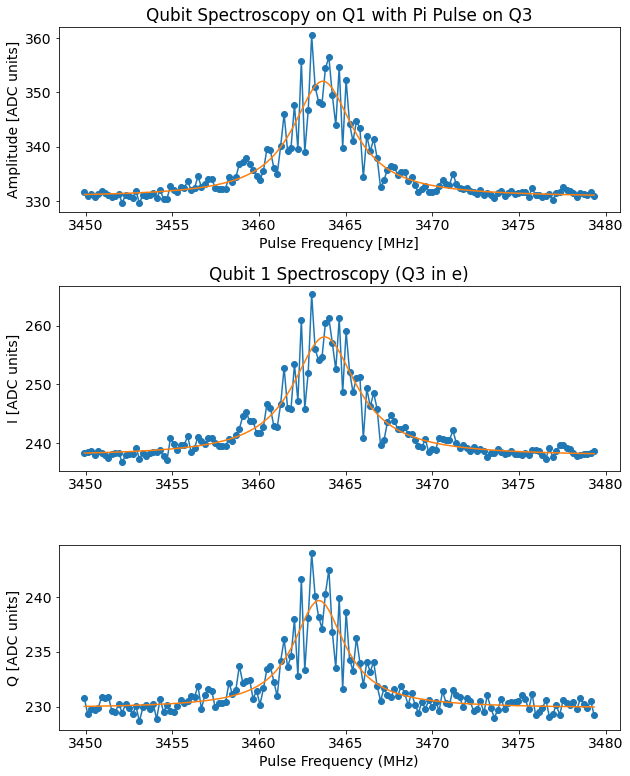

Fit Q1 frequency with ZZ shift [MHz]: 3463.460851813258
Q1 shift due to Q3 in e [MHz]: -1.266636583008676


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 145.45609132010455, HWHM 1.0833632720443094
Found peak in I at [MHz] 145.13133349189002, HWHM 1.3772404689069928
Found peak in Q at [MHz] 145.41695994637416, HWHM 1.1556059406033583


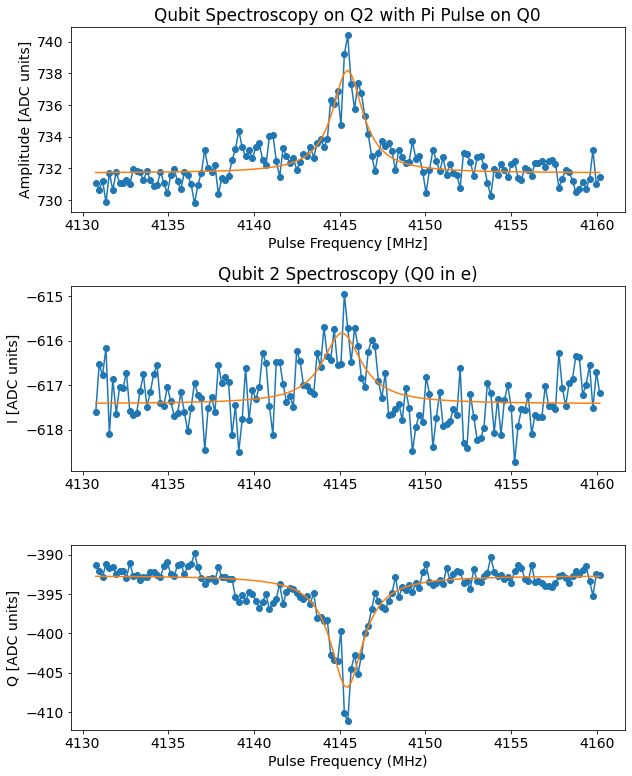

Fit Q2 frequency with ZZ shift [MHz]: 145.41695994637416
Q2 shift due to Q0 in e [MHz]: -0.15507500689682274


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 140.87806042653895, HWHM 0.8450686446014172
Found peak in I at [MHz] 140.4253477045845, HWHM 0.7995270116140618
Found peak in Q at [MHz] 140.82230972412196, HWHM 0.8900800568721531


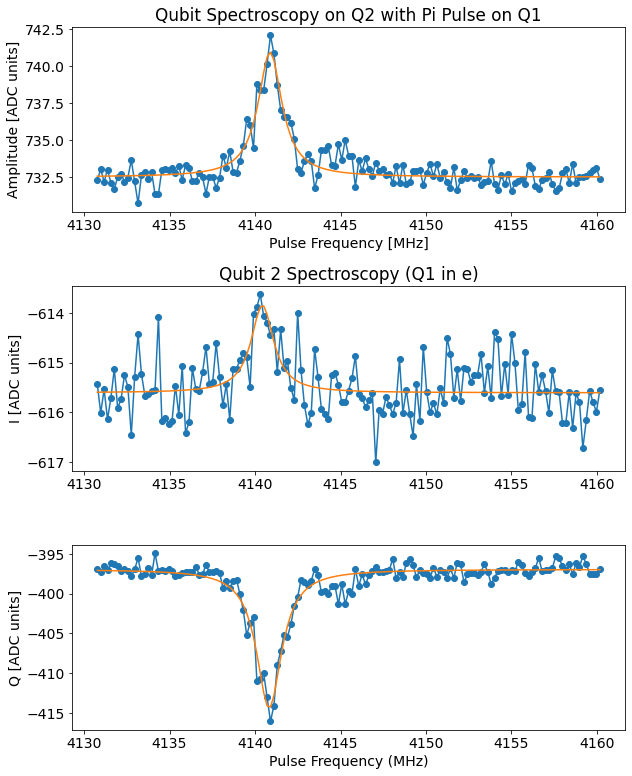

Fit Q2 frequency with ZZ shift [MHz]: 140.82230972412196
Q2 shift due to Q1 in e [MHz]: -4.749725229149021


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 145.1497811839387, HWHM 1.1013942844044502
Found peak in I at [MHz] 145.49314239635535, HWHM 1.3367661227636938
Found peak in Q at [MHz] 145.19904655973735, HWHM 1.1333851458150623


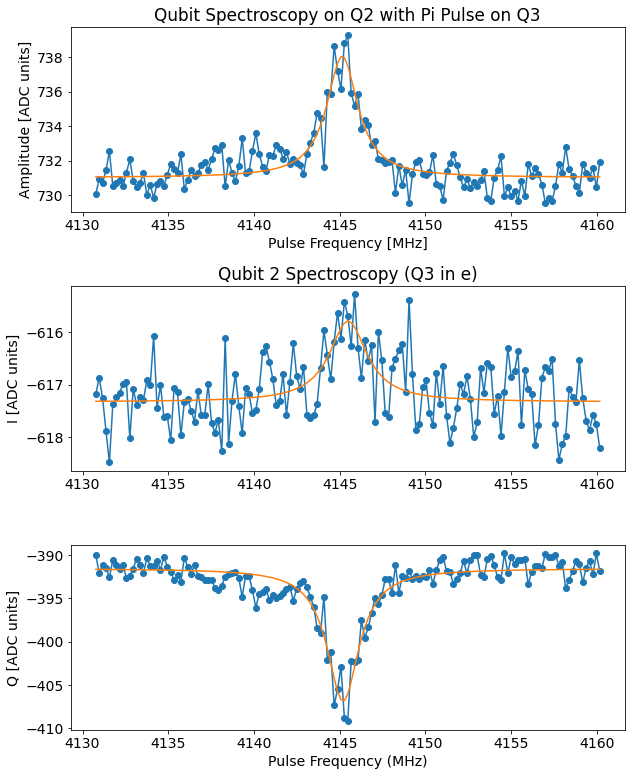

Fit Q2 frequency with ZZ shift [MHz]: 145.19904655973735
Q2 shift due to Q3 in e [MHz]: -0.3729883935336318


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 425.7744242380834, HWHM 1.8123770935415575
Found peak in I at [MHz] 425.5677978807135, HWHM 1.775999530768855
Found peak in Q at [MHz] 425.93349963034296, HWHM 1.8267000811055059


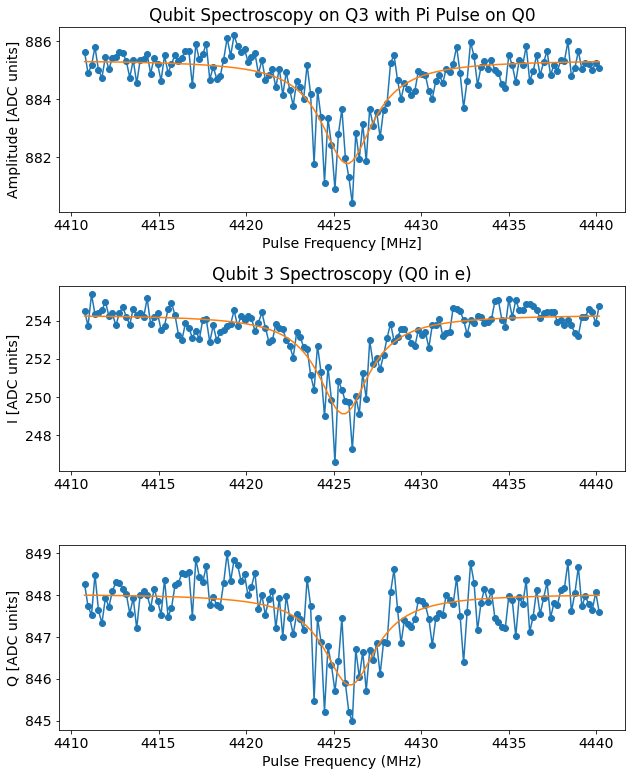

Fit Q3 frequency with ZZ shift [MHz]: 425.5677978807135
Q3 shift due to Q0 in e [MHz]: -0.002202119286494053


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 425.0358434078705, HWHM 1.1664363503166388
Found peak in I at [MHz] 424.9166050120873, HWHM 1.4944648402648455
Found peak in Q at [MHz] 425.08360185268765, HWHM 0.9733257307043326


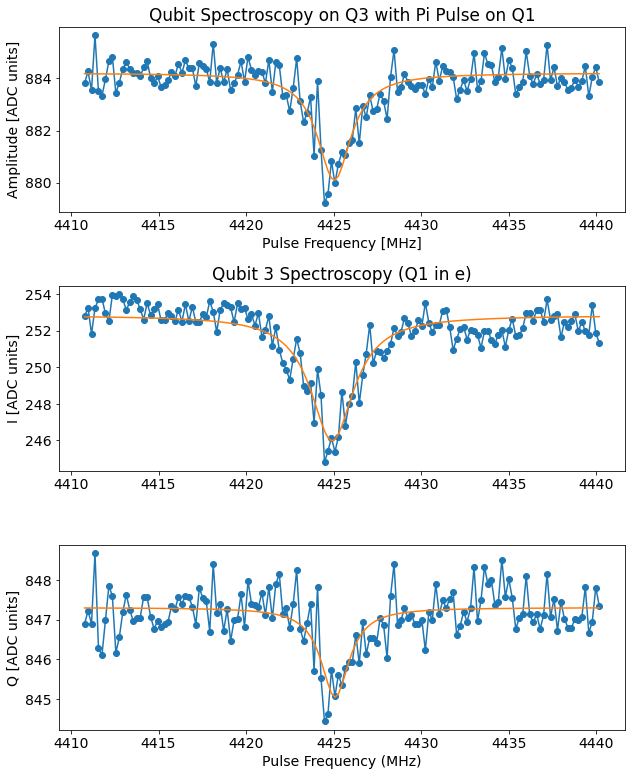

Fit Q3 frequency with ZZ shift [MHz]: 424.9166050120873
Q3 shift due to Q1 in e [MHz]: -0.6533949879126908


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 425.65419213368676, HWHM 1.3954420009376982
Found peak in I at [MHz] 425.6617247375082, HWHM 0.9697328217200565
Found peak in Q at [MHz] 425.6360326254796, HWHM 1.587927864119582


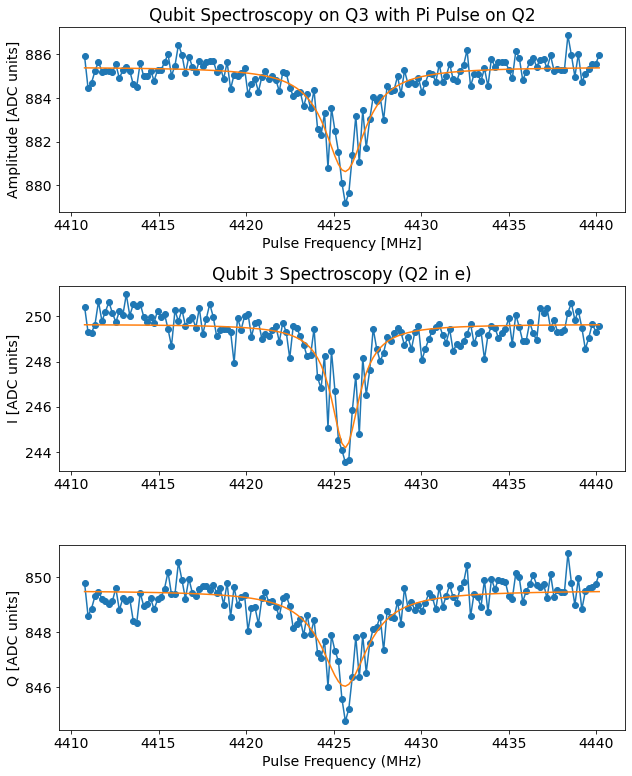

Fit Q3 frequency with ZZ shift [MHz]: 425.65419213368676
Q3 shift due to Q2 in e [MHz]: 0.08419213368676992
[[ 0.00000000e+00 -3.35893837e+00 -2.82767879e+00 -3.02562240e+00]
 [-6.94327149e-01  0.00000000e+00 -5.11343721e+00 -1.26663658e+00]
 [-1.55075007e-01 -4.74972523e+00  0.00000000e+00 -3.72988394e-01]
 [-2.20211929e-03 -6.53394988e-01  8.41921337e-02  0.00000000e+00]]


In [10]:
for qubit0 in range(4):
    for qubit1 in range(4):
        if qubit1 == qubit0: continue
        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}{qubit1}",
            config_file=config_path,
        )
        
        span = 30
        npts = 151
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=300, # Number of averages per point
            rounds=10, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=5, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
            qubits=[qubit0, qubit1],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qubit0} due to Q{qubit1} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        ZZshifts[qubit0, qubit1] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qubit0]
        print(f'Fit Q{qubit0} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qubit0} shift due to Q{qubit1} in e [MHz]: {ZZshifts[qubit0, qubit1]}')
print(ZZshifts)

In [31]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -3.3589383676320494, -2.82767878995719, -3.0256224010837514, -0.6943271490713414, 0.0, -5.113437211529799, -1.266636583008676, -0.15507500689682274, -4.749725229149021, 0.0, -0.3729883935336318, -0.002202119286494053, -0.6533949879126908, 0.08419213368676992, 0.0]


In [12]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: {ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]}')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3464.03316125 3464.7274884  3459.61405118 3463.46085181]


# Get couplings by optimization

In [12]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [13]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [14]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)

In [23]:
x0 = np.array([100, 100, 100, 10, 10, 10])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds , method='L-BFGS-B')
print(f'Success: {result.success}')
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]: {1e3*result.x}')
gs_opt = result.x

qubit freqs [4805.50359795 3464.44964777 4145.57203495 4425.57      ]
alphas [-188.45783249 -100.18920616 -224.47579811 -149.80566031]
Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [50.84015064 50.77135719 36.61617422  8.99679894  7.84830439  3.45721853]


In [24]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -1.29245068 -0.29774537 -0.60203966]
 [-0.46038592  0.         -3.92177415 -0.54621319]
 [-0.26801877 -4.80542282  0.         -0.36463781]
 [-0.66568256 -0.93876965 -0.39080745  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.         -0.87641384 -0.28287852 -0.63386517]
 [-0.87641384  0.         -4.36359582 -0.74248785]
 [-0.28287852 -4.36359582  0.         -0.37772406]
 [-0.63386517 -0.74248785 -0.37772406  0.        ]]
Optimization error: 0.8164431192822162


# ZZ shifted pi pulse calibrations for Q1

In [9]:
save_data = True
saved_files = []

In [14]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q1_ZZ=[0]*4,
    )

######### BEGINNING QUBIT 0 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.8689499661300615
Pi length from avgi data [us]: 0.013431292938502109
	Pi/2 length from avgi data [us]: 0.006715646469251054

Decay from avgq [us] 0.23834187870438173
Pi length from avgq data [us]: 0.014468065626827915
Pi/2 length from avgq data [us]: 0.007234032813413957


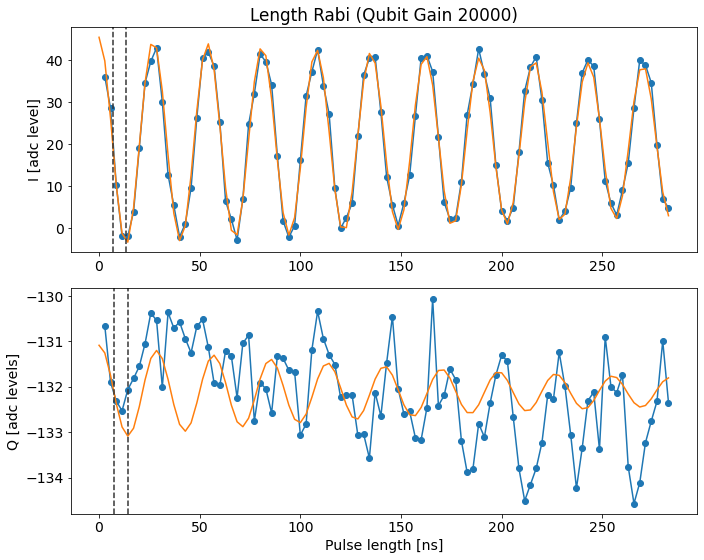

Will use sigma 0.015 for amplitude rabi
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00009_length_rabi_ZZ_qubit01.h5
-------- Amp rabi --------


  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.001453396524486572, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Pi gain from avgi data [dac units]: 27530
	Pi/2 gain from avgi data [dac units]: 13765
Pi gain from avgq data [dac units]: 27777
	Pi/2 gain from avgq data [dac units]: 13888


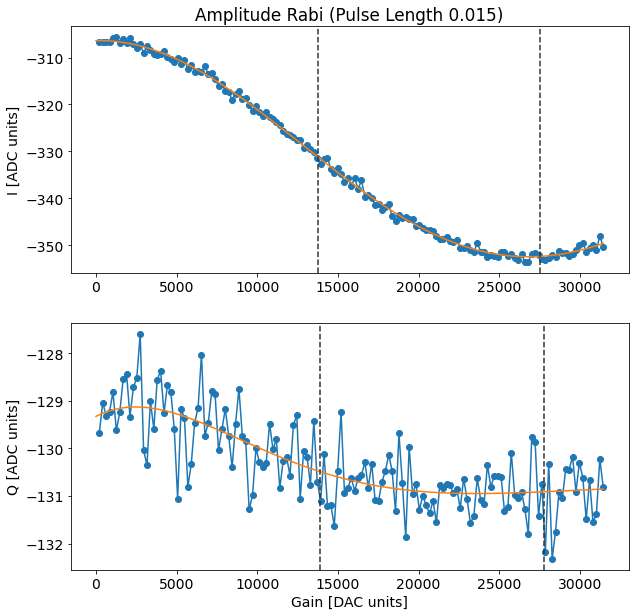

*Set Q1 pi pulse sigma with Q0 in e to 0.015*
*Set Q1 pi pulse gain with Q0 in e to 27777*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00005_amp_rabi_qubit01.h5
-------- Ramsey --------


  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 27.999719999999996, which is out of bounds 0.04697939597315437 to 7.046909395973155. Instead init to 3.5469443959731546
Current pi pulse frequency: 3463.6655790699174
Fit frequency from I [MHz]: 0.8406802606730576 +/- 0.0023582069123231062
Suggested new pi pulse frequency from fit I [MHz]:
 	3463.824898809244
 	3461.824898809244
T2 Ramsey from fit I [us]: 3.1013992330825824
Fit frequency from Q [MHz]: 3.9808665290499876 +/- 0.23830123323014926
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3460.6847125408676
 	3458.6847125408676
T2 Ramsey from fit Q [us]: 0.9680167563960568


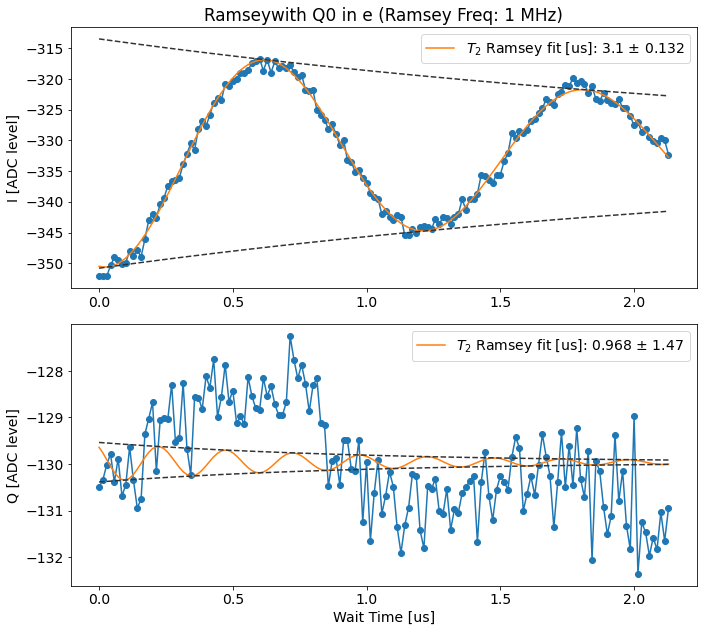

*Set Q1 pi pulse freq with Q0 in e to 3463.826339688734*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00010_ramsey_qubit1.h5



######### BEGINNING QUBIT 2 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 76.99923000000001, which is out of bounds 0.3535318181818182 to 53.02977272727273. Instead init to 26.691652272727275
Decay from avgi [us] 0.8862320811750105
Pi length from avgi data [us]: 0.024712893082012
	Pi/2 length from avgi data [us]: 0.012356446541006

Decay from avgq [us] 0.6811498707004006
Pi length from avgq data [us]: 0.02528006496676242
Pi/2 length from avgq data [us]: 0.01264003248338121


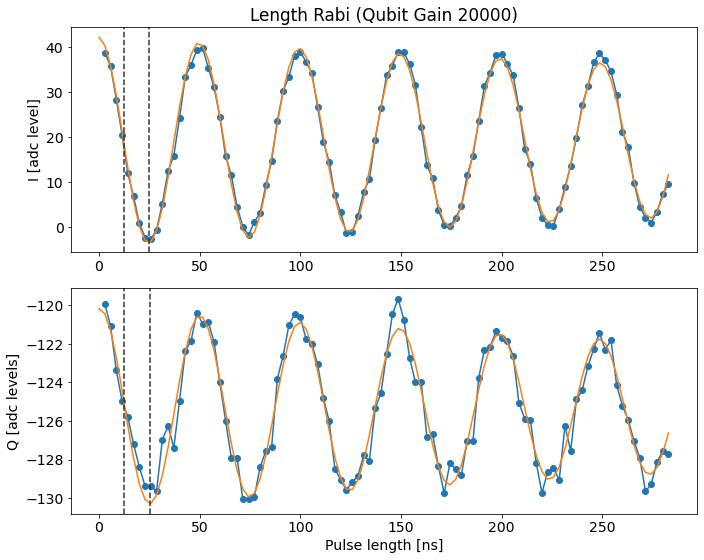

Will use sigma 0.024187907740573854 for amplitude rabi
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00005_length_rabi_ZZ_qubit21.h5
-------- Amp rabi --------


  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0012954186413902055, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Pi gain from avgi data [dac units]: 16840
	Pi/2 gain from avgi data [dac units]: 8420
Pi gain from avgq data [dac units]: 16644
	Pi/2 gain from avgq data [dac units]: 8322


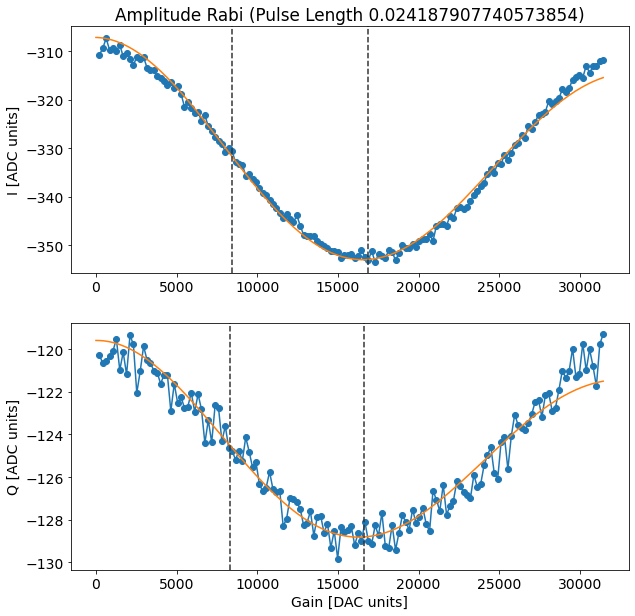

*Set Q1 pi pulse sigma with Q2 in e to 0.024187907740573854*
*Set Q1 pi pulse gain with Q2 in e to 16840*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00002_amp_rabi_qubit21.h5
-------- Ramsey --------


  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 3459.718643790527
Fit frequency from I [MHz]: 1.0487460936012996 +/- 0.002018079720936694
Suggested new pi pulse frequency from fit I [MHz]:
 	3459.6698976969255
 	3457.6698976969255
T2 Ramsey from fit I [us]: 6.4808596938544865
Fit frequency from Q [MHz]: 1.0345473226312358 +/- 0.006628913836072743
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3459.684096467896
 	3457.684096467896
T2 Ramsey from fit Q [us]: 4.793861608439664


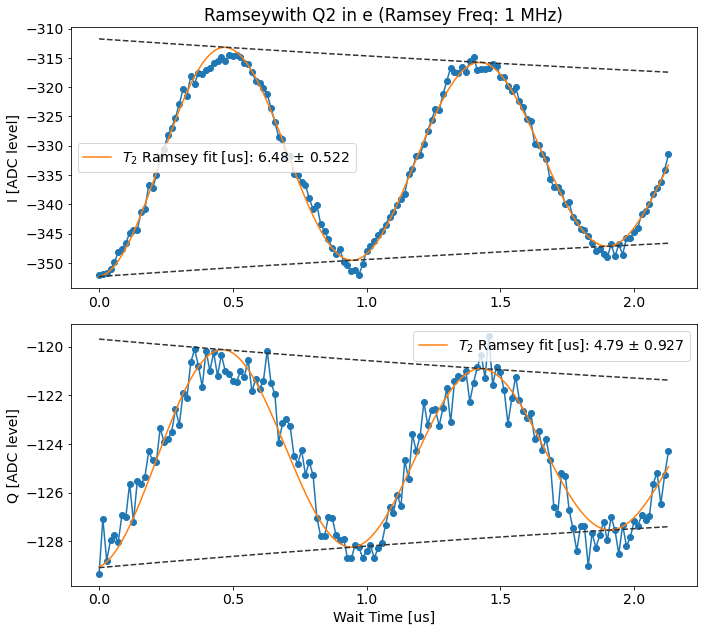

*Set Q1 pi pulse freq with Q2 in e to 3459.6698976969255*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00011_ramsey_qubit1.h5



######### BEGINNING QUBIT 3 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.7486131491321399
Pi length from avgi data [us]: 0.013349535744412049
	Pi/2 length from avgi data [us]: 0.006674767872206024

Decay from avgq [us] 0.5797953747451962
Pi length from avgq data [us]: 0.014044166750732055
Pi/2 length from avgq data [us]: 0.0070220833753660275


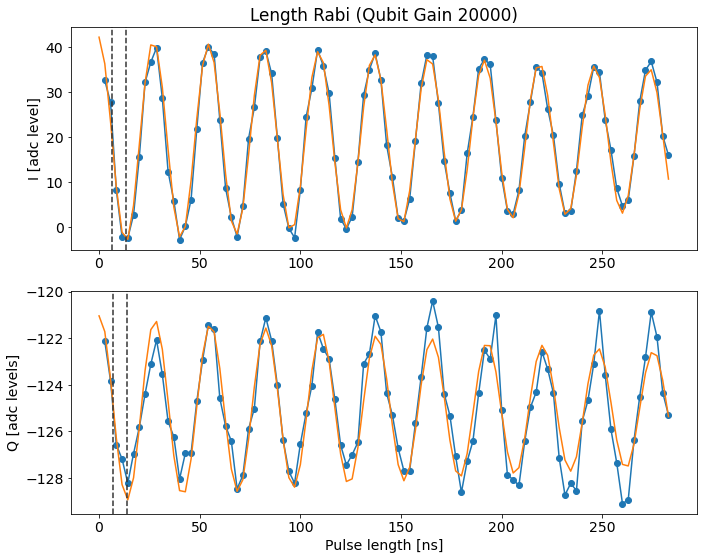

Will use sigma 0.015 for amplitude rabi
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00002_length_rabi_ZZ_qubit31.h5
-------- Amp rabi --------


  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0014218009478672987, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645


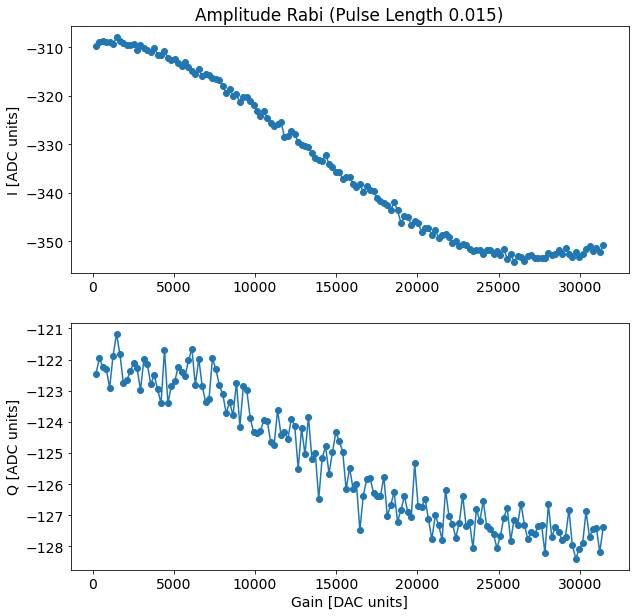

*Set Q1 pi pulse sigma with Q3 in e to 0.015*
*Set Q1 pi pulse gain with Q3 in e to 30000*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_amp_rabi_qubit31.h5
-------- Ramsey --------


  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 3463.5163174610875
Fit frequency from I [MHz]: 1.046085953809412 +/- 0.006891678898690486
Suggested new pi pulse frequency from fit I [MHz]:
 	3463.470231507278
 	3461.470231507278
T2 Ramsey from fit I [us]: 4.283767830188129
Fit frequency from Q [MHz]: 1.0058480520209503 +/- 0.008913448144239021
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3463.5104694090664
 	3461.5104694090664
T2 Ramsey from fit Q [us]: 4.525667382254323


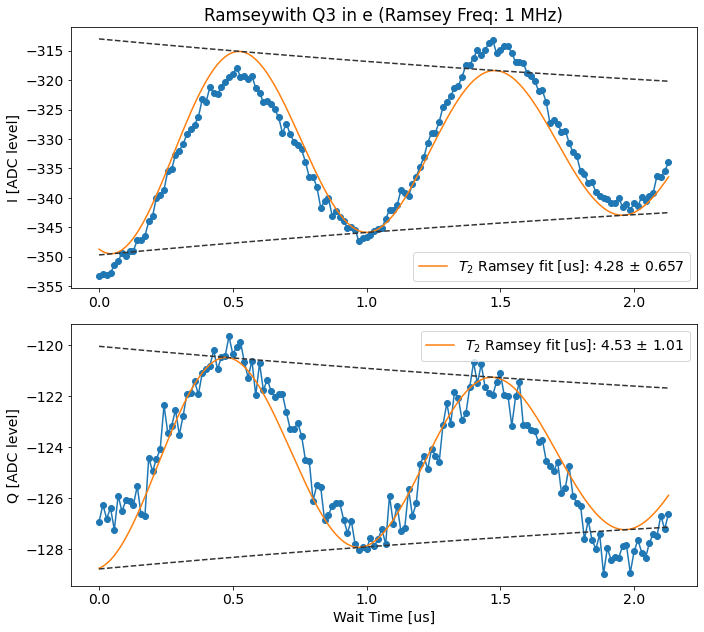

*Set Q1 pi pulse freq with Q3 in e to 3463.5104694090664*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00012_ramsey_qubit1.h5





In [23]:
q1 = 1
# for q0 in [2]:
for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    print(f"-------- length rabi --------")
    lengthrabiZZ = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_ZZ_qubit{q0}{q1}",
        config_file=config_path,
    )
    lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    lengthrabiZZ.cfg.expt = dict(
        start=0, # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        expts=101,
        reps=4000,
        gain=20000,
        pulse_type='gauss',
        qubits=[q0, q1],
        checkZZ=True,
        checkEF=False, 
    )

    try:
        import Pyro4.util
        try:
            lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        lengthrabiZZ.analyze(fit=True)
    
        lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
        lengthrabiZZ.display(fit=True)
        p = lengthrabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
        else: pi_len = (3/2 - p[2]/180)/2/p[1]
        pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain
    
        lengthrabi_decay = p[3]

        print(f'Will use sigma {pi_len} for amplitude rabi')

        if save_data: saved_files.append(lengthrabiZZ.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! LENGTH RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Amp rabi --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{q1}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = 32000
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=30,
        sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, q1],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)
        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
        results['sigma'][q0] =  pi_len
        print(f'*Set Q1 pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
        results['gain'][q0] =  int(pi_gain)
        print(f'*Set Q1 pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q1}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(5), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=1, # [MHz]
        reps=100,
        rounds=30,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, q1],
    )
    
    ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q1_ZZ[q0] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q1_ZZ[q0] = new_pi_freq
        print(f'*Set Q1 pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q1_ZZ[q0]}*')
        results['f_Q1_ZZ'][q0] =  new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {q0}!!!!!!!')
        continue
    
    print("\n\n")

In [24]:
print(results)
for saved_file in saved_files:
    print(saved_file)

{'gain': [27777, 0, 16840, 30000], 'sigma': [0.015, 0, 0.024187907740573854, 0.015], 'f_Q1_ZZ': [3463.826339688734, 0, 3459.6698976969255, 3463.5104694090664]}
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00006_length_rabi_ZZ_qubit01.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00008_ramsey_qubit1.h5
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00007_length_rabi_ZZ_qubit01.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00009_ramsey_qubit1.h5
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00004_length_rabi_ZZ_qubit21.h5
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00008_length_rabi_ZZ_qubit01.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00009_length_rabi_ZZ_qubit01.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00010_ramsey_qubit1.h5
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00005_length_rabi_ZZ_qubit21.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_221215\00011_ramsey_qubit1.h5
s:\Connie\experiments